# Data Cleaning
Data regarding education from  data.worldbank.org

## Imports

In [1]:
# Basic imports

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
sns.set()

%matplotlib inline

In [2]:
# Additional imports
import os
from education.utils import fix_census_date, is_country

In [3]:
# Paths

raw_data = '../data/raw'
processed_data = '../data/processed'

## Load Data

In [4]:
# List all files with data
file_list = os.listdir(raw_data)
print(file_list)

['EdStatsCountry-Series.csv', 'EdStatsCountry.csv', 'EdStatsData.csv', 'EdStatsFootNote.csv', 'EdStatsSeries.csv', 'Life_Expentancy.csv', 'Population.csv']


In [5]:
file_names = ['ED_CS', 'ED_C', 'ED_D', 'ED_FN', 'ED_S', 'L_E']

In [6]:
data_dict = {}

for path, name in zip(file_list, file_names):
    file_path = os.path.join(raw_data, path)
    data_dict[name] = pd.read_csv(file_path)

## Data Exploration

#### File with information about data sources

In [7]:
# Displaying basic info about data
data_dict['ED_CS'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 613 entries, 0 to 612
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   CountryCode  613 non-null    object 
 1   SeriesCode   613 non-null    object 
 2   DESCRIPTION  613 non-null    object 
 3   Unnamed: 3   0 non-null      float64
dtypes: float64(1), object(3)
memory usage: 19.3+ KB


In [8]:
# Removing last column that is fully empty
data_dict['ED_CS'].drop(columns=['Unnamed: 3'], inplace = True)

In [9]:
data_dict['ED_CS'].head()

,CountryCode,SeriesCode,DESCRIPTION
0,ABW,SP.POP.TOTL,Data sources : United Nations World Population...
1,ABW,SP.POP.GROW,Data sources: United Nations World Population ...
2,AFG,SP.POP.GROW,Data sources: United Nations World Population ...
3,AFG,NY.GDP.PCAP.PP.CD,Estimates are based on regression.
4,AFG,SP.POP.TOTL,Data sources : United Nations World Population...


In [10]:
edcs_new_path = os.path.join(processed_data, 'data_sources.csv')
data_dict['ED_CS'].to_csv(edcs_new_path,index=False)

#### File with info about country code, short and long name, region and last census

In [11]:
data_dict['ED_C'].columns

Index(['Country Code', 'Short Name', 'Table Name', 'Long Name', '2-alpha code',
       'Currency Unit', 'Special Notes', 'Region', 'Income Group', 'WB-2 code',
       'National accounts base year', 'National accounts reference year',
       'SNA price valuation', 'Lending category', 'Other groups',
       'System of National Accounts', 'Alternative conversion factor',
       'PPP survey year', 'Balance of Payments Manual in use',
       'External debt Reporting status', 'System of trade',
       'Government Accounting concept', 'IMF data dissemination standard',
       'Latest population census', 'Latest household survey',
       'Source of most recent Income and expenditure data',
       'Vital registration complete', 'Latest agricultural census',
       'Latest industrial data', 'Latest trade data',
       'Latest water withdrawal data', 'Unnamed: 31'],
      dtype='object')

In [12]:
# Choosing columns important for education stats analysis and displaying basic info
ED_C_cols = ['Country Code','Short Name','Region','Income Group',
            'Latest population census']

data_dict['ED_C'][ED_C_cols].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 241 entries, 0 to 240
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Country Code              241 non-null    object
 1   Short Name                241 non-null    object
 2   Region                    214 non-null    object
 3   Income Group              214 non-null    object
 4   Latest population census  213 non-null    object
dtypes: object(5)
memory usage: 9.5+ KB


In [13]:
# Investigating empty entries for latest census year
data_dict['ED_C'][data_dict['ED_C']['Latest population census'].isnull()][['Short Name']]

,Short Name
5,Arab World
47,Curaçao
57,East Asia & Pacific (developing only)
58,East Asia & Pacific (all income levels)
59,Europe & Central Asia (developing only)
60,Europe & Central Asia (all income levels)
63,Euro area
68,European Union
89,High income
92,Heavily indebted poor countries (HIPC)


In [14]:
# Creating list of regions/groups included as countries
# Curacao, Nauru and St. Martin are very small countries that might not have proper census  
regions = data_dict['ED_C'][data_dict['ED_C']['Latest population census'].isnull()]['Short Name'].to_list()
regions.remove('Curaçao')
regions.remove('St. Martin (French part)')
regions.remove('Nauru')

In [15]:
# creating column with info if entity is country or region/group
data_dict['ED_C']['Is_Country']=data_dict['ED_C']['Short Name'].apply(is_country)

In [16]:
countries = data_dict['ED_C'][data_dict['ED_C']['Is_Country']]

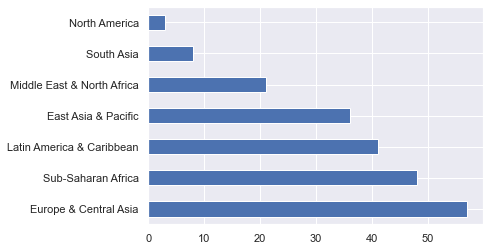

In [17]:
countries['Region'].value_counts().plot(kind='barh')
plt.show()

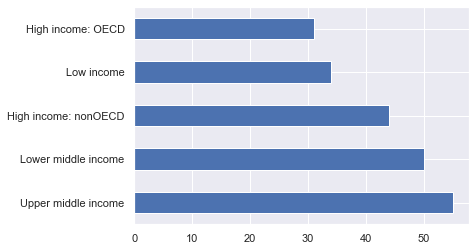

In [18]:
countries['Income Group'].value_counts().plot(kind='barh')
plt.show()

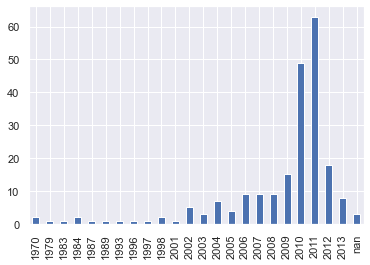

In [19]:
# Fixing census year which includes notes and year values
data_dict['ED_C']['POP_census_year'] = data_dict['ED_C']['Latest population census'].apply(fix_census_date)
countries = data_dict['ED_C'][data_dict['ED_C']['Is_Country']]

# Displaying last census year stats
countries['POP_census_year'].value_counts().sort_index().plot(kind='bar')
plt.show()

In [20]:
ED_C_cols = ['Country Code','Short Name','Region','Income Group','POP_census_year', 'Is_Country']

In [21]:
edcs_new_path = os.path.join(processed_data, 'countries_info.csv')
data_dict['ED_C'][ED_C_cols].to_csv(edcs_new_path,index=False)

#### File with data_series code explanation

In [22]:
data_dict['ED_S'].columns

Index(['Series Code', 'Topic', 'Indicator Name', 'Short definition',
       'Long definition', 'Unit of measure', 'Periodicity', 'Base Period',
       'Other notes', 'Aggregation method', 'Limitations and exceptions',
       'Notes from original source', 'General comments', 'Source',
       'Statistical concept and methodology', 'Development relevance',
       'Related source links', 'Other web links', 'Related indicators',
       'License Type', 'Unnamed: 20'],
      dtype='object')

In [23]:
data_dict['ED_S'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3665 entries, 0 to 3664
Data columns (total 21 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Series Code                          3665 non-null   object 
 1   Topic                                3665 non-null   object 
 2   Indicator Name                       3665 non-null   object 
 3   Short definition                     2156 non-null   object 
 4   Long definition                      3665 non-null   object 
 5   Unit of measure                      0 non-null      float64
 6   Periodicity                          99 non-null     object 
 7   Base Period                          314 non-null    object 
 8   Other notes                          552 non-null    object 
 9   Aggregation method                   47 non-null     object 
 10  Limitations and exceptions           14 non-null     object 
 11  Notes from original source    

In [24]:
# dropping columns with no data

data_dict['ED_S'].dropna(axis=1, how='all', inplace=True)
data_dict['ED_S'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3665 entries, 0 to 3664
Data columns (total 15 columns):
 #   Column                               Non-Null Count  Dtype 
---  ------                               --------------  ----- 
 0   Series Code                          3665 non-null   object
 1   Topic                                3665 non-null   object
 2   Indicator Name                       3665 non-null   object
 3   Short definition                     2156 non-null   object
 4   Long definition                      3665 non-null   object
 5   Periodicity                          99 non-null     object
 6   Base Period                          314 non-null    object
 7   Other notes                          552 non-null    object
 8   Aggregation method                   47 non-null     object
 9   Limitations and exceptions           14 non-null     object
 10  General comments                     14 non-null     object
 11  Source                               3665 n

In [25]:
ED_S_cols = ['Series Code', 'Topic', 'Indicator Name', 'Long definition', 'Source']

In [26]:
eds_new_path = os.path.join(processed_data, 'data_explain.csv')
data_dict['ED_S'][ED_S_cols].to_csv(eds_new_path,index=False)

#### File with data series code, year and source description

In [27]:
data_dict['ED_FN'].head()

,CountryCode,SeriesCode,Year,DESCRIPTION,Unnamed: 4
0,ABW,SE.PRE.ENRL.FE,YR2001,Country estimation.,NaN
1,ABW,SE.TER.TCHR.FE,YR2005,Country estimation.,NaN
2,ABW,SE.PRE.TCHR.FE,YR2000,Country estimation.,NaN
3,ABW,SE.SEC.ENRL.GC,YR2004,Country estimation.,NaN
4,ABW,SE.PRE.TCHR,YR2006,Country estimation.,NaN


In [28]:
data_dict['ED_FN'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 643638 entries, 0 to 643637
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   CountryCode  643638 non-null  object 
 1   SeriesCode   643638 non-null  object 
 2   Year         643638 non-null  object 
 3   DESCRIPTION  643638 non-null  object 
 4   Unnamed: 4   0 non-null       float64
dtypes: float64(1), object(4)
memory usage: 24.6+ MB


In [29]:
data_dict['ED_FN'].drop(columns=['Unnamed: 4'], inplace=True)

In [30]:
data_dict['ED_FN']['Year'] = data_dict['ED_FN']['Year'].apply(lambda x: x[2:])

In [31]:
edfn_new_path = os.path.join(processed_data, 'data_year.csv')
data_dict['ED_FN'].to_csv(edfn_new_path,index=False)

#### File with main data

In [32]:
data_dict['ED_D'].head()

,Country Name,Country Code,Indicator Name,Indicator Code,1970,1971,1972,1973,1974,1975,...,2060,2065,2070,2075,2080,2085,2090,2095,2100,Unnamed: 69
0,Arab World,ARB,"Adjusted net enrolment rate, lower secondary, ...",UIS.NERA.2,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Arab World,ARB,"Adjusted net enrolment rate, lower secondary, ...",UIS.NERA.2.F,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Arab World,ARB,"Adjusted net enrolment rate, lower secondary, ...",UIS.NERA.2.GPI,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Arab World,ARB,"Adjusted net enrolment rate, lower secondary, ...",UIS.NERA.2.M,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Arab World,ARB,"Adjusted net enrolment rate, primary, both sex...",SE.PRM.TENR,54.822121,54.894138,56.209438,57.267109,57.991138,59.36554,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [33]:
data_dict['ED_D'].columns

Index(['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code',
       '1970', '1971', '1972', '1973', '1974', '1975', '1976', '1977', '1978',
       '1979', '1980', '1981', '1982', '1983', '1984', '1985', '1986', '1987',
       '1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995', '1996',
       '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005',
       '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014',
       '2015', '2016', '2017', '2020', '2025', '2030', '2035', '2040', '2045',
       '2050', '2055', '2060', '2065', '2070', '2075', '2080', '2085', '2090',
       '2095', '2100', 'Unnamed: 69'],
      dtype='object')

In [34]:
data_dict['ED_D'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 886930 entries, 0 to 886929
Data columns (total 70 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Country Name    886930 non-null  object 
 1   Country Code    886930 non-null  object 
 2   Indicator Name  886930 non-null  object 
 3   Indicator Code  886930 non-null  object 
 4   1970            72288 non-null   float64
 5   1971            35537 non-null   float64
 6   1972            35619 non-null   float64
 7   1973            35545 non-null   float64
 8   1974            35730 non-null   float64
 9   1975            87306 non-null   float64
 10  1976            37483 non-null   float64
 11  1977            37574 non-null   float64
 12  1978            37576 non-null   float64
 13  1979            36809 non-null   float64
 14  1980            89122 non-null   float64
 15  1981            38777 non-null   float64
 16  1982            37511 non-null   float64
 17  1983      

In [35]:
data_dict['ED_D'].drop(columns=['Unnamed: 69'], inplace=True)

In [36]:
edd_new_path = os.path.join(processed_data, 'ed_data.csv')
data_dict['ED_D'].to_csv(edd_new_path,index=False)

In [37]:
data_dict['L_E'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264 entries, 0 to 263
Data columns (total 66 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Country Name    264 non-null    object 
 1   Country Code    264 non-null    object 
 2   Indicator Name  264 non-null    object 
 3   Indicator Code  264 non-null    object 
 4   1960            235 non-null    float64
 5   1961            236 non-null    float64
 6   1962            236 non-null    float64
 7   1963            235 non-null    float64
 8   1964            235 non-null    float64
 9   1965            236 non-null    float64
 10  1966            236 non-null    float64
 11  1967            236 non-null    float64
 12  1968            236 non-null    float64
 13  1969            236 non-null    float64
 14  1970            237 non-null    float64
 15  1971            236 non-null    float64
 16  1972            236 non-null    float64
 17  1973            237 non-null    flo

In [38]:
data_dict['L_E'].dropna(how='all', axis=1, inplace=True)

In [39]:
data_dict['L_E'].to_csv(os.path.join(processed_data,'life_expectancy.csv'),index=False)

In [40]:
data_dict.keys()

dict_keys(['ED_CS', 'ED_C', 'ED_D', 'ED_FN', 'ED_S', 'L_E'])

In [41]:
df_pop = pd.read_csv(os.path.join(raw_data, 'Population.csv'))

In [42]:
df_pop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264 entries, 0 to 263
Data columns (total 66 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Country Name    264 non-null    object 
 1   Country Code    264 non-null    object 
 2   Indicator Name  264 non-null    object 
 3   Indicator Code  264 non-null    object 
 4   1960            260 non-null    float64
 5   1961            260 non-null    float64
 6   1962            260 non-null    float64
 7   1963            260 non-null    float64
 8   1964            260 non-null    float64
 9   1965            260 non-null    float64
 10  1966            260 non-null    float64
 11  1967            260 non-null    float64
 12  1968            260 non-null    float64
 13  1969            260 non-null    float64
 14  1970            260 non-null    float64
 15  1971            260 non-null    float64
 16  1972            260 non-null    float64
 17  1973            260 non-null    flo

In [43]:
df_pop.dropna(how='all', axis=1, inplace=True)

In [44]:
df_pop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264 entries, 0 to 263
Data columns (total 64 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Country Name    264 non-null    object 
 1   Country Code    264 non-null    object 
 2   Indicator Name  264 non-null    object 
 3   Indicator Code  264 non-null    object 
 4   1960            260 non-null    float64
 5   1961            260 non-null    float64
 6   1962            260 non-null    float64
 7   1963            260 non-null    float64
 8   1964            260 non-null    float64
 9   1965            260 non-null    float64
 10  1966            260 non-null    float64
 11  1967            260 non-null    float64
 12  1968            260 non-null    float64
 13  1969            260 non-null    float64
 14  1970            260 non-null    float64
 15  1971            260 non-null    float64
 16  1972            260 non-null    float64
 17  1973            260 non-null    flo

In [45]:
df_pop.to_csv(os.path.join(processed_data,'POP.csv'), index=False)